In [1]:
import numpy
import scipy.sparse
from matplotlib import pyplot
import os
import pickle

## Skip these cells if you're just loading data

In [ ]:
import qubit_matmul
import shadow_reconstruction

In [2]:
splus = numpy.array([
    [0.0, 0.0],
    [1.0, 0.0]
])
sminus = numpy.array([
    [0.0, 1.0],
    [0.0, 0.0]
])
sz = numpy.array([
    [-1.0, 0.0],
    [0.0, 1.0]
])

spm = numpy.kron(splus, sminus)
smp = numpy.kron(sminus, splus)
szz = numpy.kron(sz,sz)
szi = numpy.kron(sz,numpy.eye(2))
siz = numpy.kron(numpy.eye(2),sz)

def make_z(i):
    return qubit_matmul.TensorMatf64([i], sz.flatten())

def make_zz(i,j):
    return qubit_matmul.TensorMatf64([i,j], szz.flatten())

def make_pm(i,j):
    return qubit_matmul.TensorMatf64([i, j], spm.flatten())

def make_pmpm(i,j,k,l):
    return qubit_matmul.TensorMatf64([i, j,k,l], numpy.kron(spm,spm).flatten())

In [3]:
base_dirs = {
    "/home/sumner/Desktop/NumConsShadows/xxz_l16_jm2_open/": (16, -2.0),
    "/home/sumner/Desktop/NumConsShadows/xxz_l16_jm1_open/": (16, -1.0),
    "/home/sumner/Desktop/NumConsShadows/xxz_l16_jm05_open/": (16, -0.5),
    "/home/sumner/Desktop/NumConsShadows/xxz_l16_j0_open/": (16, 0.0),
}

data = {}

for k, (l, j) in base_dirs.items():
    gs = None
    all_samples = []
    for bb, _, ff in os.walk(k):
        for f in ff:
            filename = os.path.join(bb,f)
            if f.endswith('.data'):
                samples = shadow_reconstruction.Samples.load_from(filename)
                all_samples.append(samples)
            elif gs is None and f.endswith(".npz"):
                gs = numpy.load(filename)['gs']
    acc = all_samples[0]
    for s in all_samples[1:]:
        acc.add_from(s)
    data[k] = (l,j,acc,gs)

# Continue from here

In [2]:
if not os.path.exists('plot_data.pickle'):
    plot_data = []
    for (l, j, super_samples, gs) in data.values():
        samples = super_samples # Subset if desired
        recon_data = []
        recon_data_std = []
        truth_data = []

        recon = shadow_reconstruction.Reconstruction()
        for r in range(1,l):
            corr_check = make_pm(0,r).get_sparse(l)
            ground_truth = gs @ (corr_check @ gs)
            truth_data.append(ground_truth)

            string = ['I'] * l
            string[0] = '+'
            string[r] = '-'
            string = ''.join(string)
            estimates = recon.estimate_string_for_each_sample(string, samples)
            recon_data.append(estimates.mean())
            recon_data_std.append(estimates.std()/numpy.sqrt(len(estimates)))
        recon_data = numpy.array(recon_data)
        recon_data_std = numpy.array(recon_data_std)
        truth_data = numpy.array(truth_data)
        plot_data.append((l,j,truth_data, recon_data, recon_data_std))
    with open('plot_data.pickle', 'wb') as w:
        pickle.dump(plot_data, w)
else:
    with open('plot_data.pickle', 'rb') as f:
        plot_data = pickle.load(f)

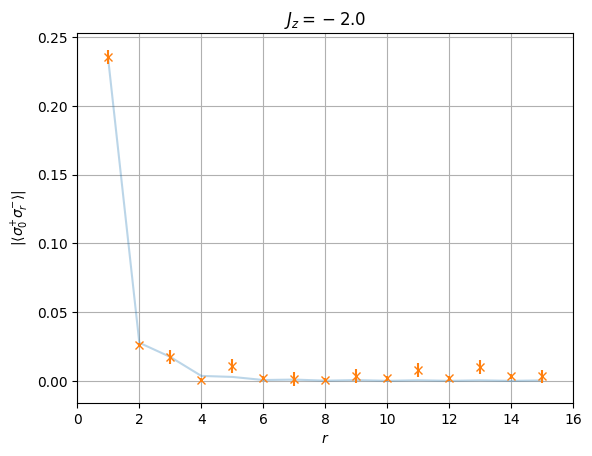

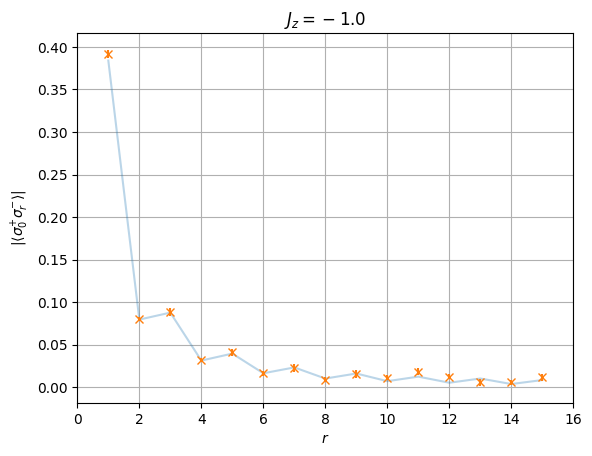

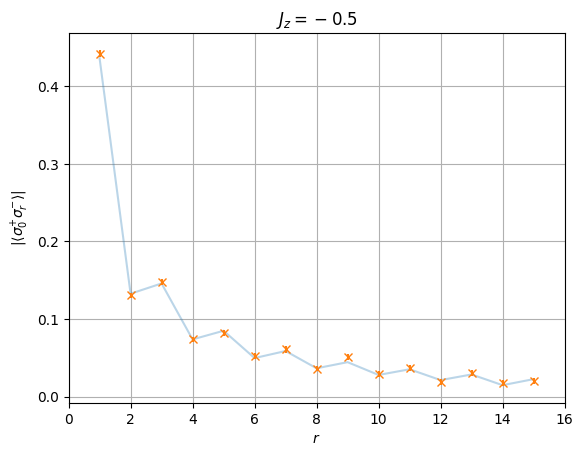

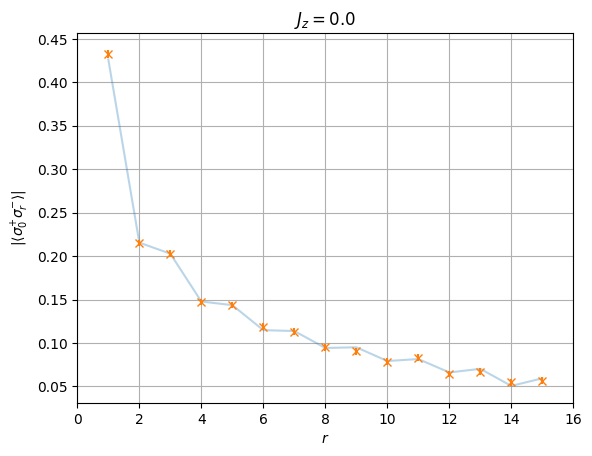

In [3]:
for (l,j,truth_data, recon_data, recon_data_std) in plot_data:
    pyplot.plot(range(1,l), abs(truth_data), alpha=0.3)
    pyplot.errorbar(range(1,l), abs(recon_data), yerr=recon_data_std, fmt='x')
    pyplot.title(r'$J_z={:.1f}$'.format(j))
    pyplot.ylabel(r'$|\langle \sigma^{+}_0 \sigma^{-}_r \rangle|$')
    pyplot.xlabel('$r$')
    pyplot.xlim([0,16])
    pyplot.grid()
    pyplot.savefig('pmj{:.3f}.jpeg'.format(j))
    pyplot.show()

In [4]:
if not os.path.exists('zzplot_data.pickle'):
    zzplot_data = []
    for (l, j, super_samples, gs) in data.values():
        samples = super_samples # Subset if desired
        recon_data = []
        recon_data_std = []
        truth_data = []

        recon = shadow_reconstruction.Reconstruction()
        for r in range(1,l):
            corr_check = make_zz(0,r).get_sparse(l)
            ground_truth = gs @ (corr_check @ gs)
            truth_data.append(ground_truth)

            string = ['I'] * l
            string[0] = 'Z'
            string[r] = 'Z'
            string = ''.join(string)
            estimates = recon.estimate_string_for_each_sample(string, samples)
            recon_data.append(estimates.mean())
            recon_data_std.append(estimates.std()/numpy.sqrt(len(estimates)))
        recon_data = numpy.array(recon_data)
        recon_data_std = numpy.array(recon_data_std)
        truth_data = numpy.array(truth_data)
        zzplot_data.append((l,j,truth_data, recon_data, recon_data_std))
    
    with open('zzplot_data.pickle', 'wb') as w:
        pickle.dump(zzplot_data, w)
else:
    with open('zzplot_data.pickle', 'rb') as f:
        zzplot_data = pickle.load(f)

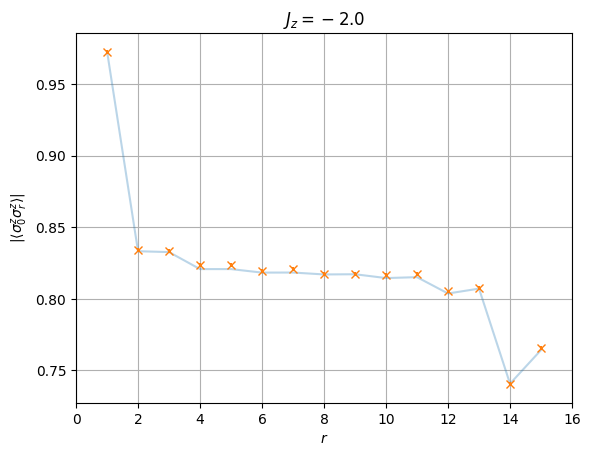

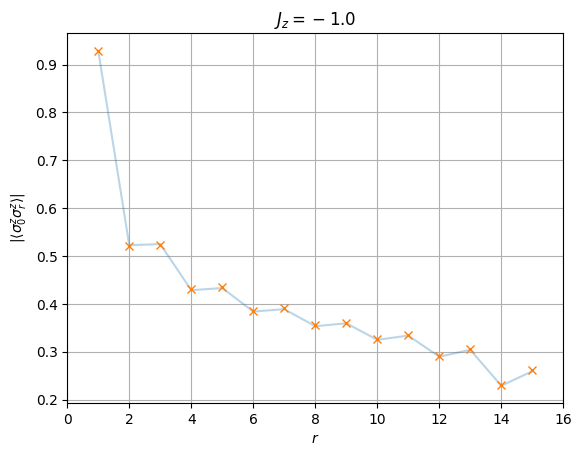

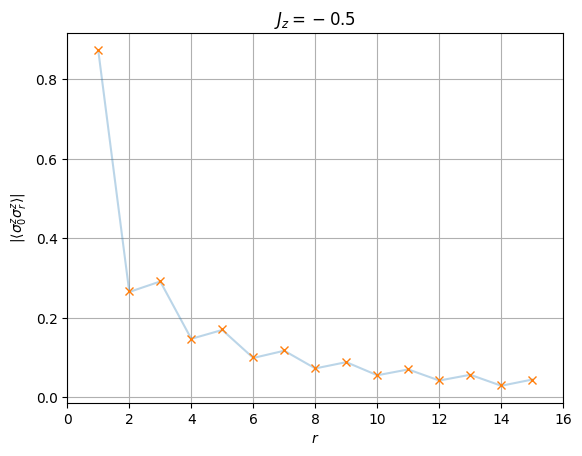

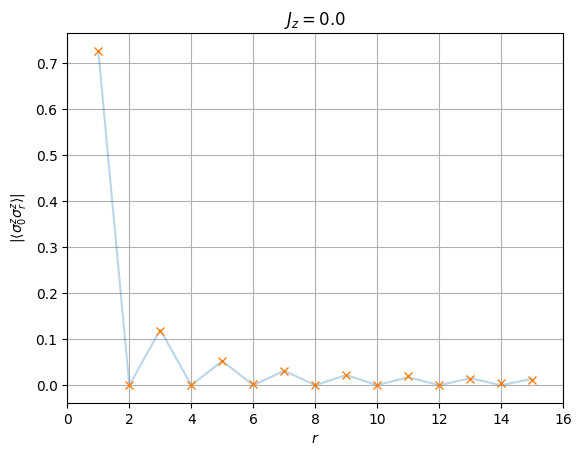

In [5]:
for (l,j,truth_data, recon_data, recon_data_std) in zzplot_data:
    pyplot.plot(range(1,l), abs(truth_data), alpha=0.3)
    pyplot.errorbar(range(1,l), abs(recon_data), yerr=recon_data_std, fmt='x')
    pyplot.title(r'$J_z={:.1f}$'.format(j))
    pyplot.ylabel(r'$|\langle \sigma^{z}_0 \sigma^{z}_r \rangle|$')
    pyplot.xlabel('$r$')
    pyplot.grid()
    pyplot.xlim([0,16])
    pyplot.savefig('zzj{:.3f}.jpeg'.format(j))
    pyplot.show()